In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

import warnings 
warnings.filterwarnings(action='ignore')

from matplotlib import font_manager, rc

In [18]:
train = pd.read_csv('dataset/data/train.csv')

In [19]:
test = pd.read_csv('dataset/data/test_date.csv')

In [20]:
test.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '년', '월', '일'],
      dtype='object')

## 식사가능자

In [21]:
test['식사가능자'] = test['본사정원수'] - test['본사휴가자수'] - test['본사출장자수'] - test['현본사소속재택근무자수']

## 요일평균 식계

In [22]:
def make_dow_avg(df_test, df_prev):
    dow_avg_ln = df_prev.groupby('요일').mean()['중식계']
    dow_avg_dn = df_prev.groupby('요일').mean()['석식계']
    
    df_test['요일평균중식계'] = 0
    tmp = dow_avg_ln.values
    for i in range(len(tmp)):
        df_test['요일평균중식계'][df_test['요일'] == i] = tmp[i]
        
    df_test['요일평균석식계'] = 0
    tmp = dow_avg_dn.values
    for i in range(len(tmp)):
        df_test['요일평균석식계'][df_test['요일'] == i] = tmp[i]
    
    return df_test

## 월평균식계

In [23]:
def make_month_avg(df_test, df_prev):
    month_avg_ln = df_prev.groupby('월').mean()['중식계']
    month_avg_dn = df_prev.groupby('월').mean()['석식계']
    
    df_test['월평균중식계'] = 0
    tmp = month_avg_ln
    tmp_k = tmp.keys(); tmp_v = tmp.values
    for i in tmp_k:
        df_test['월평균중식계'][df_test['월'] == i] = tmp_v[i-1]
        
    df_test['월평균석식계'] = 0
    tmp = month_avg_dn
    tmp_k = tmp.keys(); tmp_v = tmp.values
    for i in tmp_k:
        df_test['월평균석식계'][df_test['월'] == i] = tmp_v[i-1]
        
    return df_test

## 공휴일전후

In [24]:
test['공휴일전후'] = 0
test['공휴일전후'][10] =1
test['공휴일전후'][20] = 1

# 모델

## 점심

In [25]:
from pycaret.regression import *

In [26]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '년', '월', '일',
       '식사가능자', '전주중식계', '전주석식계', '요일평균중식계', '요일평균석식계', '월평균중식계', '월평균석식계',
       '공휴일전후'],
      dtype='object')

In [40]:
X_train_ln = train[['요일', '본사시간외근무명령서승인건수', '요일평균중식계', '월평균중식계', '공휴일전후',
                '본사휴가자수', '본사출장자수', '식사가능자', '중식계']]

In [41]:
X_train_ln

,요일,본사시간외근무명령서승인건수,요일평균중식계,월평균중식계,공휴일전후,본사휴가자수,본사출장자수,식사가능자,중식계
0,3,238,1144.331950,989.623656,0,50,150,2401.0,1039.0
1,4,319,925.620833,989.623656,0,50,173,2378.0,867.0
2,2,111,905.213389,989.623656,0,56,180,2365.0,1017.0
3,1,355,823.991803,989.623656,1,104,220,2277.0,978.0
4,0,34,653.609959,989.623656,0,278,181,2142.0,925.0
...,...,...,...,...,...,...,...,...,...
1200,2,4,905.213389,934.247525,0,75,198,2319.0,1093.0
1201,1,462,823.991803,934.247525,0,92,231,2309.0,832.0
1202,0,1,653.609959,934.247525,0,255,248,2177.0,579.0
1203,3,616,1144.331950,934.247525,0,107,153,2396.0,1145.0


In [42]:
reg = setup(session_id=1,
            data=X_train_ln,
            target='중식계',
            #numeric_imputation = 'mean',
            normalize = True,
            #categorical_features=['월', '요일', '공휴일전후'],
            silent=True)

,Description,Value
0,session_id,1
1,Target,중식계
2,Original Data,"(1205, 9)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 12)"


In [43]:
top5 = compare_models(n_select=5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,71.2318,8965.9985,93.9394,0.7921,0.1159,0.0861,0.5280
gbr,Gradient Boosting Regressor,71.6987,9188.7388,94.9770,0.7870,0.1166,0.0865,0.0220
rf,Random Forest Regressor,74.7794,9933.5249,98.8920,0.7704,0.1226,0.0908,0.1830
et,Extra Trees Regressor,75.5542,10330.2492,100.8986,0.7621,0.1261,0.0924,0.1750
lightgbm,Light Gradient Boosting Machine,76.0612,10114.2297,100.0402,0.7650,0.1241,0.0919,0.0590
huber,Huber Regressor,76.8121,10528.1556,101.7810,0.7558,0.1290,0.0929,0.0090
xgboost,Extreme Gradient Boosting,76.9038,10300.0470,100.4662,0.7603,0.1233,0.0928,0.1840
br,Bayesian Ridge,77.3097,10345.2465,101.0065,0.7603,0.1262,0.0936,0.0050
ridge,Ridge Regression,77.3135,10342.2909,101.0076,0.7604,0.1264,0.0936,0.0060
lar,Least Angle Regression,77.3360,10352.2905,101.0677,0.7602,0.1268,0.0936,0.0060


In [44]:
gbr_l = tune_model(create_model('catboost'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,84.6423,13008.0523,114.0528,0.7377,0.1488,0.1055
1,82.4558,11840.6405,108.8147,0.6570,0.1167,0.0905
2,68.6218,7842.6008,88.5585,0.8136,0.1131,0.0862
3,62.6017,7120.3989,84.3825,0.8493,0.1197,0.0848
4,60.1581,5959.8150,77.1998,0.8490,0.0879,0.0679
5,67.6211,9018.0076,94.9632,0.8005,0.1248,0.0850
6,81.0960,12740.5148,112.8739,0.7128,0.1288,0.0938
7,70.4191,7487.8421,86.5323,0.7716,0.0983,0.0799
8,71.6768,8998.9224,94.8627,0.8151,0.1134,0.0857
9,71.0350,8958.3021,94.6483,0.8344,0.1369,0.0951


In [45]:
gbr_l = tune_model(create_model('gbr', criterion='mae'), optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,88.2727,13746.7424,117.2465,0.7228,0.1524,0.1099
1,82.7647,12924.7530,113.6871,0.6256,0.1237,0.0907
2,66.3824,7994.5610,89.4123,0.8100,0.1121,0.0826
3,62.3398,7374.8927,85.8772,0.8439,0.1218,0.0856
4,59.5834,5892.5583,76.7630,0.8507,0.0885,0.0673
5,69.2123,9104.5558,95.4178,0.7986,0.1243,0.0858
6,75.4561,11448.2869,106.9967,0.7419,0.1211,0.0869
7,71.9898,7911.8279,88.9485,0.7586,0.1041,0.0832
8,70.9892,8850.8715,94.0791,0.8182,0.1081,0.0836
9,70.2892,9311.9494,96.4984,0.8278,0.1409,0.0952


In [46]:
pred_holdouts = predict_model(gbr_l)
final_model_l = finalize_model(gbr_l)
final_model_l

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,70.9156,9193.5047,95.8828,0.7873,0.1200,0.0884


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.05, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=260,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

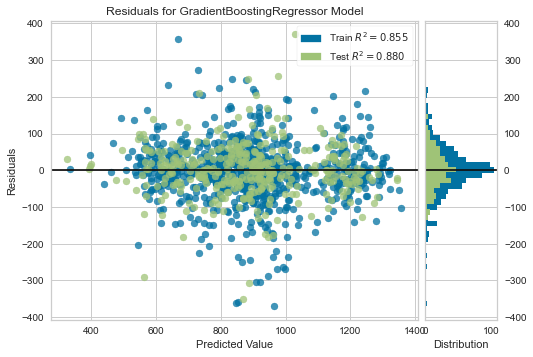

In [47]:
plot_model(final_model_l)

## 저녁

In [67]:
train = pd.read_csv('dataset/data/train_dinner.csv')

In [68]:
X_train_dn = train[['요일', '본사시간외근무명령서승인건수', '공휴일전후', '요일평균석식계', '월평균석식계', '본사출장자수',
                 '식사가능자', '월', '일', '석식계']]

In [69]:
reg = setup(session_id=2,
            data=X_train_dn,
            target='석식계',
            #numeric_imputation = 'mean',
            normalize = True,
            #categorical_features=['월', '요일', '공휴일전후'],
            silent=True)

,Description,Value
0,session_id,2
1,Target,석식계
2,Original Data,"(1162, 10)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(813, 24)"


In [70]:
top5 = compare_models(n_select=5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,50.1862,4488.0186,66.6345,0.6066,0.1667,0.1233,0.5010
rf,Random Forest Regressor,51.1697,4739.2325,68.5505,0.5861,0.1714,0.1260,0.1960
gbr,Gradient Boosting Regressor,51.9970,4679.5324,68.2056,0.5912,0.1701,0.1269,0.0240
et,Extra Trees Regressor,52.0095,4907.2024,69.8170,0.5698,0.1731,0.1260,0.1780
lightgbm,Light Gradient Boosting Machine,53.5686,5205.8228,71.9005,0.5456,0.1788,0.1323,0.0620
xgboost,Extreme Gradient Boosting,54.1823,5154.2439,71.4170,0.5527,0.1796,0.1324,0.2270
huber,Huber Regressor,59.8419,6250.8833,78.8389,0.4537,0.1982,0.1489,0.0080
lr,Linear Regression,59.8610,6163.0786,78.3187,0.4629,0.1953,0.1481,0.3560
ridge,Ridge Regression,59.9030,6156.3078,78.2797,0.4638,0.1954,0.1484,0.0060
lasso,Lasso Regression,59.9222,6156.4440,78.2965,0.4652,0.1982,0.1507,0.0060


In [82]:
blended_d = blend_models(top5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,47.4287,4633.7633,68.0718,0.5622,0.2007,0.1301
1,52.0008,5155.9924,71.8052,0.5415,0.2010,0.1375
2,47.5794,3759.3169,61.3133,0.7171,0.1429,0.1090
3,46.5249,3734.9193,61.1140,0.5943,0.1309,0.1007
4,52.6696,4560.0120,67.5279,0.7102,0.1891,0.1373
5,43.4203,3042.3766,55.1577,0.7197,0.1244,0.0972
6,47.1933,3782.9602,61.5058,0.6776,0.1392,0.1085
7,52.5613,5534.8090,74.3963,0.4697,0.1603,0.1183
8,53.8043,5516.1777,74.2710,0.5684,0.2036,0.1485
9,54.3565,4948.3654,70.3446,0.5346,0.1706,0.1357


In [52]:
params = {'learning_rate': [0.0, 0.1, 0.09, 0.089, 0.08],
                  'booster': ['gbtree', 'gblinear', 'dart']}
xgb_ = tune_model(create_model('xgboost', gpu_id=0), optimize='MAE', custom_grid=params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,62.1833,9369.4248,96.7958,0.5769,1.1035,0.1450
1,60.3312,7256.3042,85.1839,0.3274,0.2052,0.1370
2,62.1439,7583.8779,87.0855,0.6151,0.9347,0.1231
3,56.7220,6179.6353,78.6107,0.6096,0.6057,0.1292
4,56.5045,6577.9307,81.1044,0.6354,0.7815,0.1258
5,55.5339,5508.5537,74.2196,0.6371,0.6679,0.1189
6,56.1677,5366.3232,73.2552,0.7653,0.8908,0.1243
7,55.5395,5274.3608,72.6248,0.7262,0.8180,0.1279
8,64.0048,8289.2383,91.0453,0.6036,0.7922,0.1549
9,61.7286,8596.4502,92.7170,0.6737,1.5004,0.1160


In [72]:
pred_holdouts = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
final_model_d

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,52.9680,5145.4383,71.7317,0.5690,0.1631,0.1232


VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x000001E805C3CD08>),
                            ('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   m

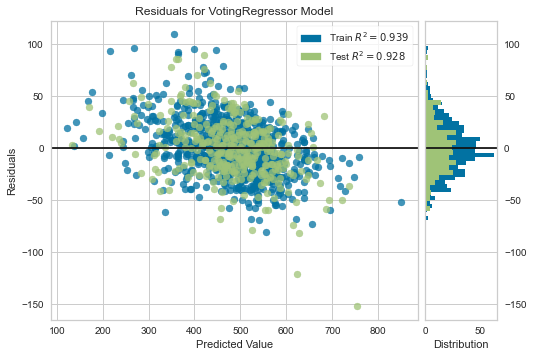

In [73]:
plot_model(final_model_d)

# 추론

## Test 5일마다 split

In [48]:
submission_df = pd.read_csv('submission/dinner_change.csv')

In [74]:
submission_df

,일자,중식계,석식계
0,2021-01-27,980.654934,407.950771
1,2021-01-28,931.951907,437.960553
2,2021-01-29,622.249575,282.717662
3,2021-02-01,1209.063556,580.492267
4,2021-02-02,1047.370794,538.109406
5,2021-02-03,1081.800389,0.000000
6,2021-02-04,1007.308563,0.000000
7,2021-02-05,718.116797,0.000000
8,2021-02-08,1317.386555,0.000000
9,2021-02-09,1044.131765,0.000000


In [75]:
test.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '년', '월', '일', '식사가능자', '공휴일전후'],
      dtype='object')

In [76]:
res = []
X_test = test[['일자', '요일', '본사시간외근무명령서승인건수', '공휴일전후', '본사출장자수', '본사휴가자수',
                 '식사가능자', '월', '일']]
X_test["중식계"] = 0
for i in range(len(X_test)):
    if i%5 == 0:
        res.append(X_test[i:i+5])

In [77]:
res = res[1:]
len(res)

9

In [78]:
res[0]

,일자,요일,본사시간외근무명령서승인건수,공휴일전후,본사출장자수,본사휴가자수,식사가능자,월,일,중식계
5,2021-02-03,2,5,0,199,59,2380.0,2,3,0
6,2021-02-04,1,476,0,211,61,2364.0,2,4,0
7,2021-02-05,0,0,0,252,169,2247.0,2,5,0
8,2021-02-08,3,690,0,174,88,2333.0,2,8,0
9,2021-02-09,4,542,0,183,94,2318.0,2,9,0


In [79]:
from datetime import timedelta
prev = train
for idx, part_test in enumerate(res):
    part_test = make_dow_avg(part_test, prev)
    part_test = make_month_avg(part_test, prev)
    
    #pred 생성
    #pred_ln = predict_model(final_model_l, part_test.drop(['일자', '월'], axis=1))
    pred_dn = predict_model(final_model_d, part_test.drop(['일자'], axis=1))
    
    #submission 업데이트
    #submission_df['중식계'][5*(idx+1):5*(idx+1)+5] = pred_ln['Label']
    
    submission_df['석식계'][5*(idx+1):5*(idx+1)+5] = pred_dn['Label']


In [80]:
submission_df

,일자,중식계,석식계
0,2021-01-27,980.654934,407.950771
1,2021-01-28,931.951907,437.960553
2,2021-01-29,622.249575,282.717662
3,2021-02-01,1209.063556,580.492267
4,2021-02-02,1047.370794,538.109406
5,2021-02-03,1081.800389,520.740234
6,2021-02-04,1007.308563,555.480545
7,2021-02-05,718.116797,421.965396
8,2021-02-08,1317.386555,689.484153
9,2021-02-09,1044.131765,586.681351


In [81]:
submission_df.to_csv('submission/fianl_change_dinner.csv', index=False)

In [ ]:

train['전주중식계'] = 0
train['전주석식계'] = 0
idx = pd.DatetimeIndex(train['일자']) + timedelta(weeks=-1)
for i in range(len(train)):
    try:
        train['전주중식계'][i] = train[train['일자'] == str(idx[i])[:10]]['중식계']
        train['전주석식계'][i] = train[train['일자'] == str(idx[i])[:10]]['석식계']
    except:
        train['전주중식계'][i] = train.iloc[i,:]['중식계']
        train['전주석식계'][i] = train.iloc[i,:]['석식계']

train[['중식계', '전주중식계', '석식계', '전주석식계', '일자']].head(10)